# Final Project: Digit Recognizer - An Active Kaggle Competition
##  Name: Gopi Miyani (10437266)
### Model : Supervised Autoencoder

- Kaggle Competition Link: https://www.kaggle.com/c/digit-recognizer/overview
- Goal: To identify digits from hand-written images


## 1. Method: Supervised Autoencoder

### 1.1. Load Data 

In [1]:
# Import Libraries

import numpy as np
import pandas as pd
from IPython.display import display, HTML

# Load Data

train_data=pd.read_csv('Data/train.csv')
test_data=pd.read_csv('Data/test.csv')

print('\nShape of train_data: '+str(train_data.shape))
print('Shape of test data: '+str(test_data.shape))


Shape of train_data: (42000, 785)
Shape of test data: (28000, 784)


In [2]:
# Extract input features and labels from tarinning data into x_train and y_train

x_train = train_data.drop(labels='label',axis=1)
#print('\n------------------ x_train Data Head ------------------\n' +str(x_train.head))
#print('\n------------------y_train Data Head ------------------\n' +str(y_train.head))
y_train=train_data['label']
print('Shape of x_train: ' +str(x_train.shape))
print('Shape of y_train: ' +str(y_train.shape))
print('number of classes: ' + str(np.max(y_train) - np.min(y_train) + 1))


Shape of x_train: (42000, 784)
Shape of y_train: (42000,)
number of classes: 10


### 1.2. Data Normalization

In [3]:
# Normalize train and test data

x_train=x_train/255.0
test_data=test_data/255.0

#print(x_train.describe())
#print(test_data.describe())

print('Shape of x_train' +str(x_train.shape))
print('Shape of test_data' +str(test_data.shape))

Shape of x_train(42000, 784)
Shape of test_data(28000, 784)


### 1.3. One-hot encode the labels
In the input, a label is a scalar in  {0,1,⋯,9} . However, such labels are not easily trainable and it is thus easier to train on an encoding of the labels. Here, a one-hot encoding is used for this purpose.

In [4]:
from keras.utils import to_categorical

def to_one_hot(y, num_class=10):
    return to_categorical(y)

y_train= to_categorical(y_train,num_classes=10)
print('Shape of y_train' +str(y_train.shape))

Using TensorFlow backend.


Shape of y_train(42000, 10)


### 1.4. Randomly partition the training set to training and validation sets
Randomly partition the 42K training samples to 2 sets:

- A training set containing 90% of total samples
- A validation set containing 10% of total samples

In [5]:
from sklearn.model_selection import train_test_split

# Train-validation split 

r_seed = 2
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=r_seed)


print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))


Shape of x_tr: (37800, 784)
Shape of y_tr: (37800, 10)
Shape of x_val: (4200, 784)
Shape of y_val: (4200, 10)


### 1.5. Build supervised auto encoder model

In [6]:
# build the supervised autoencoder network
from keras.layers import Dense, Input
from keras import models
from keras.layers import Dropout, BatchNormalization,Activation
from keras.regularizers import l1, l2, l1_l2

input_img = Input(shape=(784,), name='input_img')

# encoder network
encode1 = Dense(128, name='encode1',activation="relu")(input_img)  
encode2 = Dense(64, activation='relu', name='encode2')(encode1)
encode3 = Dense(32, activation='relu', name='encode3')(encode2)
encode4 = Dense(8, activation='relu', name='encode4')(encode3)

# The width of the bottleneck layer must be exactly 2.
bottleneck = Dense(2, activation='relu', name='bottleneck')(encode4)

# decoder network
decode1 = Dense(8, activation='relu', name='decode1')(bottleneck)
decode2 = Dense(32, activation='relu', name='decode2')(decode1)
decode3 = Dense(64, activation='relu', name='decode3')(decode2)
decode4 = Dense(128, activation='relu', name='decode4')(decode3)
decode5 = Dense(784, activation='relu', name='decode5')(decode4)

# build a classifier upon the bottleneck layer
classifier1 = Dense(256,name="classifier1")(bottleneck)
classifier1=BatchNormalization()(classifier1)
classifier1=Activation("relu")(classifier1)
classifier1=Dropout(rate=0.5)(classifier1)
                    
classifier2 = Dense(64,name="classifier2",kernel_regularizer=l2(0.001))(classifier1)                   
classifier2=Activation("relu")(classifier2)

classifier3 = Dense(10, activation='softmax',name="classifier3")(classifier2)

In [7]:
# connect the input and the two outputs
sae = models.Model(input_img, [decode5, classifier3])

sae.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          (None, 784)          0                                            
__________________________________________________________________________________________________
encode1 (Dense)                 (None, 128)          100480      input_img[0][0]                  
__________________________________________________________________________________________________
encode2 (Dense)                 (None, 64)           8256        encode1[0][0]                    
__________________________________________________________________________________________________
encode3 (Dense)                 (None, 32)           2080        encode2[0][0]                    
____________________________________________________________________________________________

In [8]:
# build the encoder model
sae_encoder = models.Model(input_img, bottleneck)
sae_encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 784)               0         
_________________________________________________________________
encode1 (Dense)              (None, 128)               100480    
_________________________________________________________________
encode2 (Dense)              (None, 64)                8256      
_________________________________________________________________
encode3 (Dense)              (None, 32)                2080      
_________________________________________________________________
encode4 (Dense)              (None, 8)                 264       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 18        
Total params: 111,098
Trainable params: 111,098
Non-trainable params: 0
_____________________________________________________

In [9]:
from keras import optimizers

sae.compile(loss=['mean_squared_error', 'categorical_crossentropy'],
            loss_weights=[1, 0.5], # to be tuned
            optimizer=optimizers.RMSprop(lr=1E-3))

history = sae.fit(x_tr, [x_tr, y_tr], 
                  batch_size=32, 
                  epochs=20, 
                  validation_data=(x_val,[x_val, y_val]))

Train on 37800 samples, validate on 4200 samples
Epoch 1/20
37800/37800 [==============================] - 9s 230us/step - loss: 0.5702 - decode5_loss: 0.0669 - classifier3_loss: 0.8969 - val_loss: 0.3401 - val_decode5_loss: 0.0602 - val_classifier3_loss: 0.4988
Epoch 2/20
37800/37800 [==============================] - 8s 199us/step - loss: 0.3459 - decode5_loss: 0.0586 - classifier3_loss: 0.5237 - val_loss: 0.3034 - val_decode5_loss: 0.0583 - val_classifier3_loss: 0.4582
Epoch 3/20
37800/37800 [==============================] - 7s 198us/step - loss: 0.2880 - decode5_loss: 0.0567 - classifier3_loss: 0.4263 - val_loss: 0.2123 - val_decode5_loss: 0.0556 - val_classifier3_loss: 0.2817
Epoch 4/20
37800/37800 [==============================] - 8s 199us/step - loss: 0.2589 - decode5_loss: 0.0559 - classifier3_loss: 0.3739 - val_loss: 0.1783 - val_decode5_loss: 0.0554 - val_classifier3_loss: 0.2190
Epoch 5/20
37800/37800 [==============================] - 7s 197us/step - loss: 0.2382 - decode

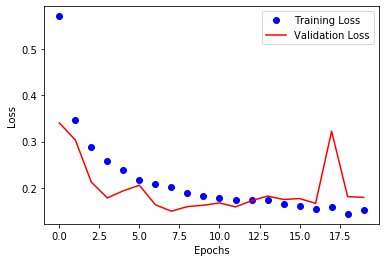

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

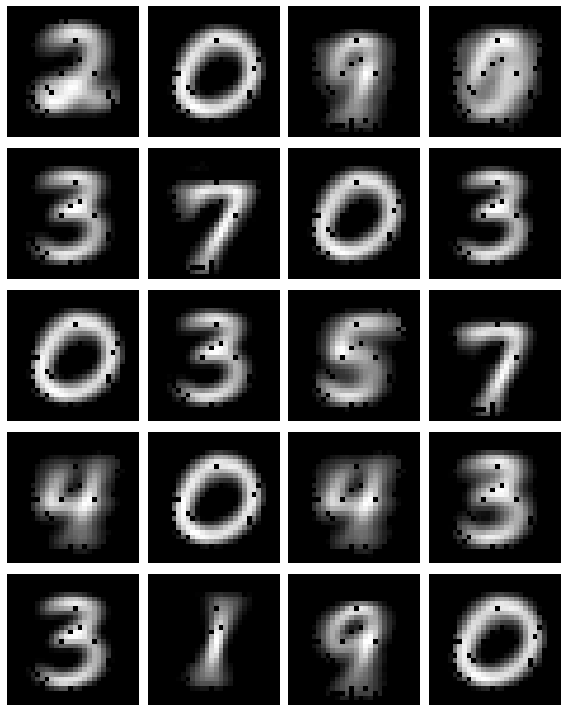

In [11]:
sae_output = sae.predict(test_data)[0].reshape((28000, 28, 28))

ROW = 5
COLUMN = 4

x = sae_output
fname = 'reconstruct_sae.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, np.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()

In [12]:
# build the encoder model
sae_encoder = models.Model(input_img, bottleneck)
sae_encoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 784)               0         
_________________________________________________________________
encode1 (Dense)              (None, 128)               100480    
_________________________________________________________________
encode2 (Dense)              (None, 64)                8256      
_________________________________________________________________
encode3 (Dense)              (None, 32)                2080      
_________________________________________________________________
encode4 (Dense)              (None, 8)                 264       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 18        
Total params: 111,098
Trainable params: 111,098
Non-trainable params: 0
_____________________________________________________

In [13]:
# extract 2D features from the training, validation, and test samples
f_tr = sae_encoder.predict(x_tr)
f_val = sae_encoder.predict(x_val)
f_te = sae_encoder.predict(test_data)


In [14]:
# build a classifier which takes the 2D features as input
from keras.layers import Dense, Input
from keras import models

input_feat = Input(shape=(2,))

hidden1 = Dense(256, activation='relu')(input_feat)
hidden2 = Dense(128, activation='relu')(hidden1)
output = Dense(10, activation='softmax')(hidden2)

classifier = models.Model(input_feat, output)

classifier.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               768       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 34,954
Trainable params: 34,954
Non-trainable params: 0
_________________________________________________________________


In [15]:
classifier.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1E-4),
                  metrics=['acc'])

history = classifier.fit(f_tr, y_tr, 
                        batch_size=32, 
                        epochs=20, 
                        validation_data=(f_val, y_val))

Train on 37800 samples, validate on 4200 samples
Epoch 1/20
37800/37800 [==============================] - 2s 62us/step - loss: 1.1124 - acc: 0.7047 - val_loss: 0.5298 - val_acc: 0.9160
Epoch 2/20
37800/37800 [==============================] - 2s 56us/step - loss: 0.2442 - acc: 0.9781 - val_loss: 0.2387 - val_acc: 0.9579
Epoch 3/20
37800/37800 [==============================] - 2s 61us/step - loss: 0.1006 - acc: 0.9832 - val_loss: 0.2066 - val_acc: 0.9586
Epoch 4/20
37800/37800 [==============================] - 2s 59us/step - loss: 0.0777 - acc: 0.9838 - val_loss: 0.2082 - val_acc: 0.9598
Epoch 5/20
37800/37800 [==============================] - 2s 59us/step - loss: 0.0726 - acc: 0.9841 - val_loss: 0.2089 - val_acc: 0.9602
Epoch 6/20
37800/37800 [==============================] - 2s 57us/step - loss: 0.0709 - acc: 0.9843 - val_loss: 0.2193 - val_acc: 0.9607
Epoch 7/20
37800/37800 [==============================] - 2s 59us/step - loss: 0.0699 - acc: 0.9847 - val_loss: 0.2155 - val_acc:

### 1.6. Compare results with simple baseline
Here, for baseline, I have used linear logistic regression model

In [22]:
#calculate accuracy
from sklearn import metrics
print('--------------------- Comparision of Supervised Autoencoder with Baseline ------------------')
print('\nValidation Accuracy Score (Logistic Regression): 0.9121428571428571') # This was calculated previoulsy in FNN model
print('Validation Accuracy Score (Supervised Autoencoder): ' +str(history.history['val_acc'][19]))

--------------------- Comparision of Supervised Autoencoder with Baseline ------------------

Validation Accuracy Score (Logistic Regression): 0.9121428571428571
Validation Accuracy Score (Supervised Autoencoder): 0.9626190662384033
